# Trabajo Computacional 2 - RNN Classifier con PyTorch Lightning

Este notebook implementa un clasificador RNN para predecir el origen de nombres utilizando PyTorch Lightning.

## Objetivos
- Adaptar la RNN simple a Pytorch Lightning
- Reemplazar las capas con los modulos RNN, LSTM y GRUs de Pytorch
- Crear un dataloader
- Guardar el modelo y las metricas según convención de lightning

- Adicionalmente se realizara lo siguiente
  - Modularizar el código en componentes reutilizables:
    - `datamodule.py`: Manejo y preprocesamiento de datos. Implementación de Dataset y Datamodule
    - `model.py`: Definición del modelo RNN
    - `eval.py`: Utilitarios para evaluacion del modelo
  - Implementación de loop de entrenamiento `rnn-training.py` para ejecución óptima en GPUs usando kernel no interactivo de python

## Instalación y configuración

Primero instalamos las dependencias necesarias e importamos las bibliotecas.

In [1]:
# Instalar PyTorch Lightning si no está instalado
# !pip install lightning

In [2]:
import os
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import time

# Importar módulos personalizados
from utils.model import RNNClassifier, find_latest_checkpoint
from utils.datamodule import RNNDataset, RNNDataModule, n_letters
from utils.eval import evaluate_model, plot_confusion_matrix, predict_name_origin

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar
torch.manual_seed(47)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.3.0+cu121
PyTorch Lightning version: 2.5.3
Device: CUDA


## Preparación de datos

Toda la lógica de procesamiento se movió a un archivo separado [datamodule.py](utils/datamodule.py) con el fin de tener un notebook más limpio y poder tener un mejor mecanismo para paralelizar el trabajo grupal. En el archivo se encuentra la implementación de:
- Utilitarios para el procesamiento de los datos:
    - Conversión a tensores
    - One-hot encoding de los inputs
- Clase `RNNDataset` que maneja la carga e iteración de los datos. También maneja el balanceo de los datos como se observará más adelante.
- Clase `RNNDataModule` que maneja la división de los datos en entrenamiento, validación y test y los carga adecuadamente a través de Dataloaders para el flujo de trabajo a través de Lightning

### Distribución de datos y balanceo

 Al cargar e inspeccionar los datos, estos se encontraban muy desbalanceados. Para poder definir las épocas adecuadamente se hizo un sobremuestreo de las clases que tenían menos datos y con esto tener una distribución más equitativa de los datos. Los resultados se pueden observar a continuación al cargar el dataset.

In [3]:
# Cargamos el dataset
dataset = RNNDataset(data_path="./data/names/", balanced=True, verbose=True)

Los datos ya están disponibles.
Cargando datos desde ./data/names/...


Polish: 139 ejemplos
Greek: 203 ejemplos
Chinese: 268 ejemplos
Scottish: 100 ejemplos
Italian: 709 ejemplos
German: 724 ejemplos
Dutch: 297 ejemplos
Arabic: 2000 ejemplos
Portuguese: 74 ejemplos
English: 3668 ejemplos
Russian: 9408 ejemplos
French: 277 ejemplos
Czech: 519 ejemplos
Japanese: 991 ejemplos
Spanish: 298 ejemplos
Korean: 94 ejemplos
Vietnamese: 73 ejemplos
Irish: 232 ejemplos

Balanceando dataset...
Polish - nuevo tamaño: 9313
Greek - nuevo tamaño: 9338
Chinese - nuevo tamaño: 9380
Scottish - nuevo tamaño: 9400
Italian - nuevo tamaño: 9217
German - nuevo tamaño: 8688
Dutch - nuevo tamaño: 9207
Arabic - nuevo tamaño: 8000
Portuguese - nuevo tamaño: 9398
English - nuevo tamaño: 7336
Russian - tamaño original: 9408
French - nuevo tamaño: 9141
Czech - nuevo tamaño: 9342
Japanese - nuevo tamaño: 8919
Spanish - nuevo tamaño: 9238
Korean - nuevo tamaño: 9400
Vietnamese - nuevo tamaño: 9344
Irish - nuevo tamaño: 9280


In [4]:
categories = dataset.categories

print(f"Número total de categorías: {len(categories)}")
print(f"Categorías disponibles: {categories}")

print(f"\nEjemplos de entrenamiento:")
for i in range(5):
    category, line, category_tensor, line_tensor = dataset.get_random_sample()
    print(f"category = {category} / line = {line}")


Número total de categorías: 18
Categorías disponibles: ['Polish', 'Greek', 'Chinese', 'Scottish', 'Italian', 'German', 'Dutch', 'Arabic', 'Portuguese', 'English', 'Russian', 'French', 'Czech', 'Japanese', 'Spanish', 'Korean', 'Vietnamese', 'Irish']

Ejemplos de entrenamiento:
category = Japanese / line = Masoni
category = Russian / line = Verbin
category = German / line = Spellmeyer
category = Portuguese / line = Araullo
category = Korean / line = Park 


## Modelo RNN

La definición del modelo, al igual que el data module se definió por separado para tener un notebook más limpio y poder mejorar el proceso de trabajo grupal. Los detalles de la implementación del modelo estan en [model.py](utils/model.py). La implementación del modelo incluye:
- Implementación de clase `RNNClassifier` como un módulo de Lightning.
- Carga automática del **ultimo checkpoint** y método utilitario para buscar el último checkpoint
- Soporte para manejar distintos modelos base de pytorch
    - RNN
    - LSTM (en éste caso se tuvo que modificar el input de entrada al modelo para incluir el *cell state*)
    - GRU

## Entrenamiento del modelo

La ejecución del modulo de PyTorch Lightning dentro del notebook resultó ser extremadamente ineficiente tomando mucho tiempo en ejecutar una sola época por lo cual se procedió a implementar el loop de entrenamiento en un script de python que se puede encontrar en [rnn-training.py](rnn-training.py). En éste caso se utilizó `subprocess` para poder ejecutar el script en un shell nativo a través del kernel no interactivo pero al mismo tiempo poder visualizar el output del mismo en el notebook.

In [5]:
import subprocess
import sys

# Ejecuta el script de entrenamiento usando subprocess
script_path = "rnn-training.py"

# Verificar que el script existe
if not os.path.exists(script_path):
    print(f"Error: No se encontró el archivo {script_path}")
    exit(1)

print("Iniciando entrenamiento del modelo RNN...")

try:
    # Ejecutar el script con subprocess
    process = subprocess.Popen(
        [sys.executable, script_path],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        universal_newlines=True,
        bufsize=1
    )
    
    # Mostrar la salida en tiempo real
    for line in process.stdout:
        print(line.rstrip())
    
    # Esperar a que termine el proceso
    process.wait()
    
    if process.returncode == 0:
        print("Entrenamiento completado exitosamente!")
    else:
        print("\n" + "=" * 60)
        print(f"Error durante el entrenamiento. Código de salida: {process.returncode}")
        
except Exception as e:
    print(f"Error al ejecutar el script: {str(e)}")

Iniciando entrenamiento del modelo RNN...


PyTorch version: 2.3.0+cu121
PyTorch Lightning version: 2.5.3
Device: CUDA
Configuración del entrenamiento:
  hidden_size: 128
  learning_rate: 0.00125
  n_epochs: 100
  batch_size: 32
  num_workers: 40
Probando modelo base: rnn
Creando instancia de modelo RNN (rnn)...
Los datos ya están disponibles.
Modelo creado exitosamente!
Arquitectura del modelo:
  - Input size: 57 (caracteres)
  - Hidden size: 128
  - Output size: 18 (categorías)
  - Learning rate: 0.00125
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Cargando modelo desde checkpoint: ./checkpoints/rnn/epoch=75-step=77596.ckpt
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
PyTorch version: 2.3.0+cu121
PyTorch Lightning version: 2.5.3
Device: CUDA
Configuración del entrenamiento:
  hidden_size: 128
  learning_rate: 0.00125
  n_epochs: 100
  batch_size: 32
  num_workers: 40
Probando modelo base: rnn
Creando instancia de modelo RNN (rnn)...
Los datos ya es

## Evaluación del modelo

La definición del modelo, al igual que el data module se definió por separado para tener un notebook más limpio y poder mejorar el proceso de trabajo grupal. Los detalles de la implementación del modelo estan en [eval.py](utils/eval.py). La implementación del modelo incluye:
- Abstracción del proceso de evaluación
- Métodos utilitarios para visualización de métricas y resultados

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_li

Evaluando el modelo...

Evaluando modelo: RNN
Los datos ya están disponibles.


/home/eaguayo/.local/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/rnn-classifier/rnn/eval exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9386593103408813     │
└───────────────────────────┴───────────────────────────┘

/home/eaguayo/workspace/DeepLearning/rnn-classifier/utils/eval.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + categories, rotation=90)
/home/eaguayo/workspace/DeepLearning/rnn-classifier/utils/eval.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + categories)


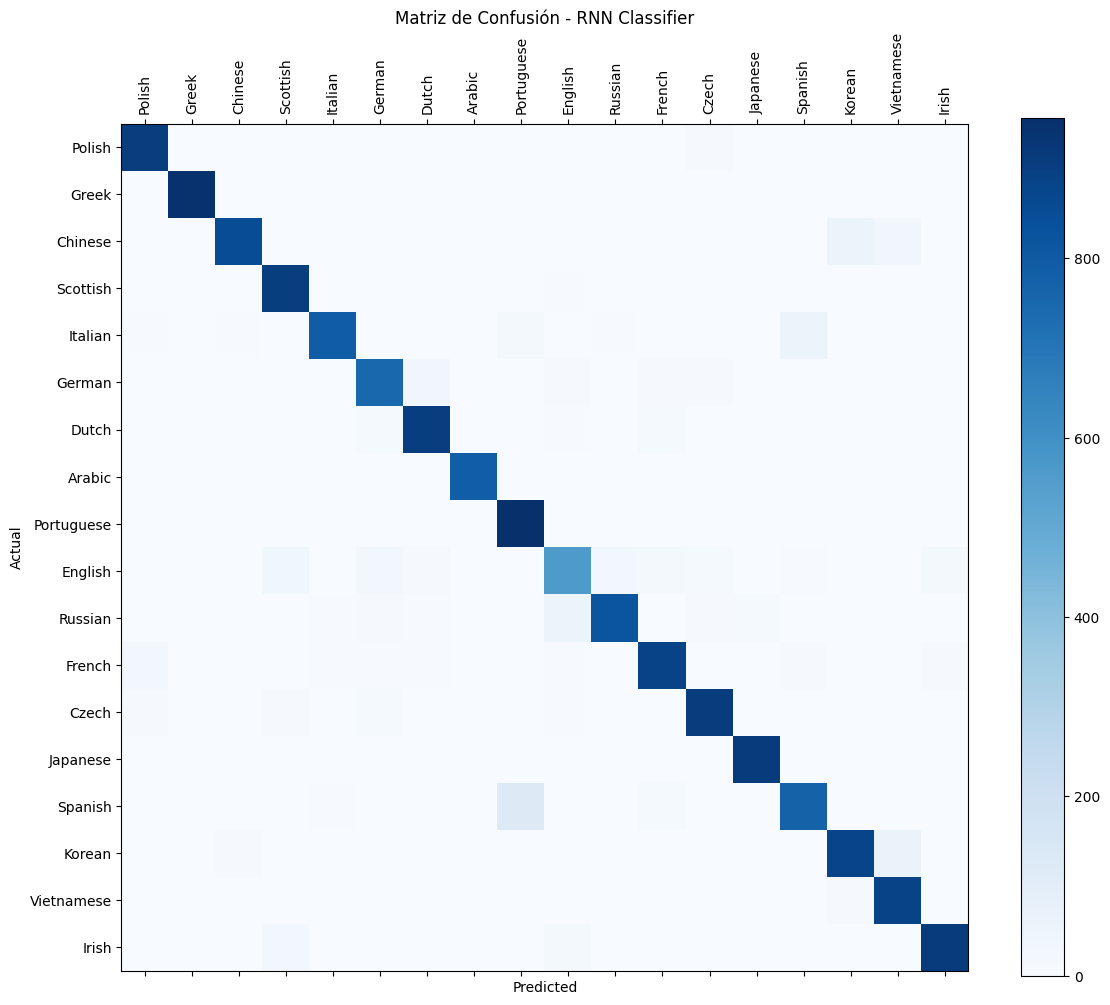

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_li


Evaluando modelo: LSTM
Los datos ya están disponibles.


/home/eaguayo/.local/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/rnn-classifier/lstm/eval exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.96051424741745      │
└───────────────────────────┴───────────────────────────┘

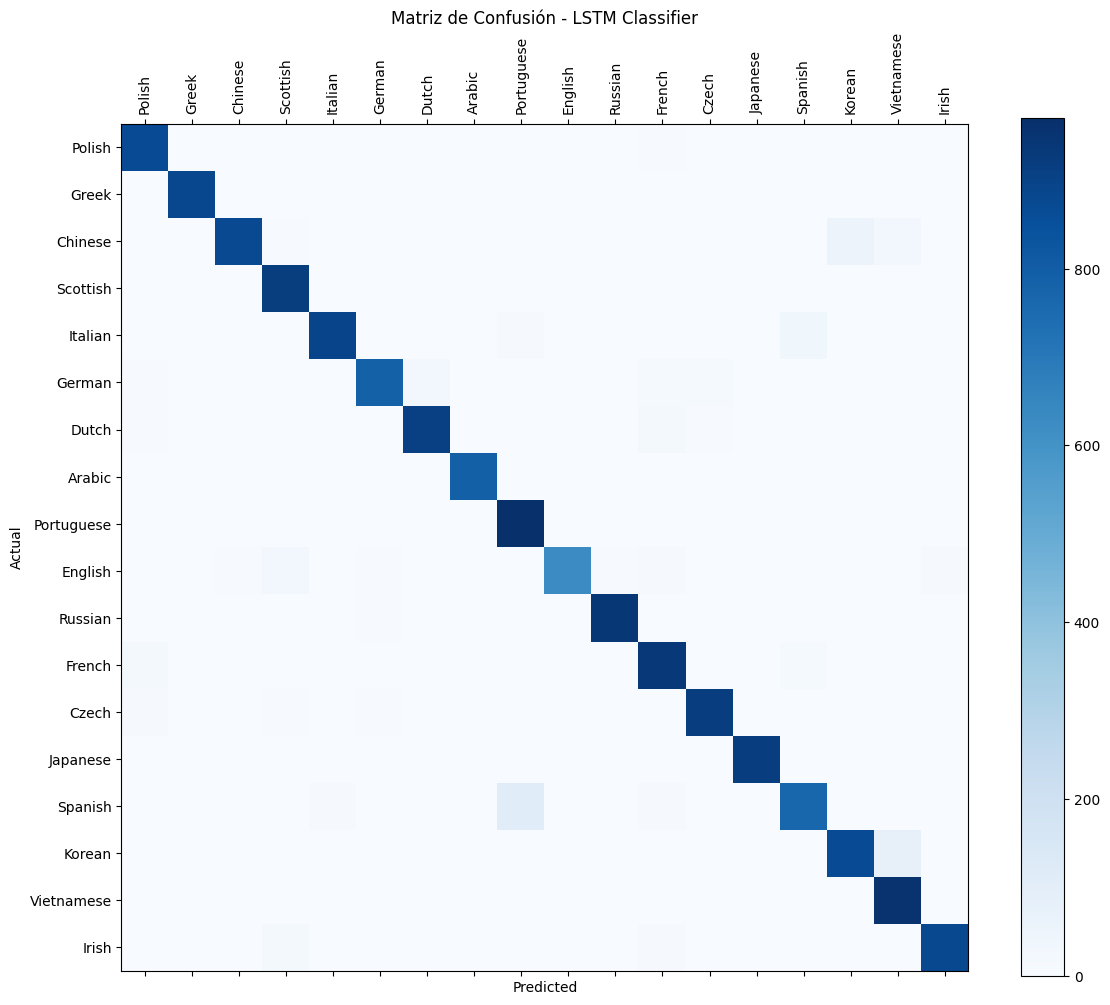

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_li


Evaluando modelo: GRU
Los datos ya están disponibles.


/home/eaguayo/.local/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/rnn-classifier/gru/eval exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9571472406387329     │
└───────────────────────────┴───────────────────────────┘

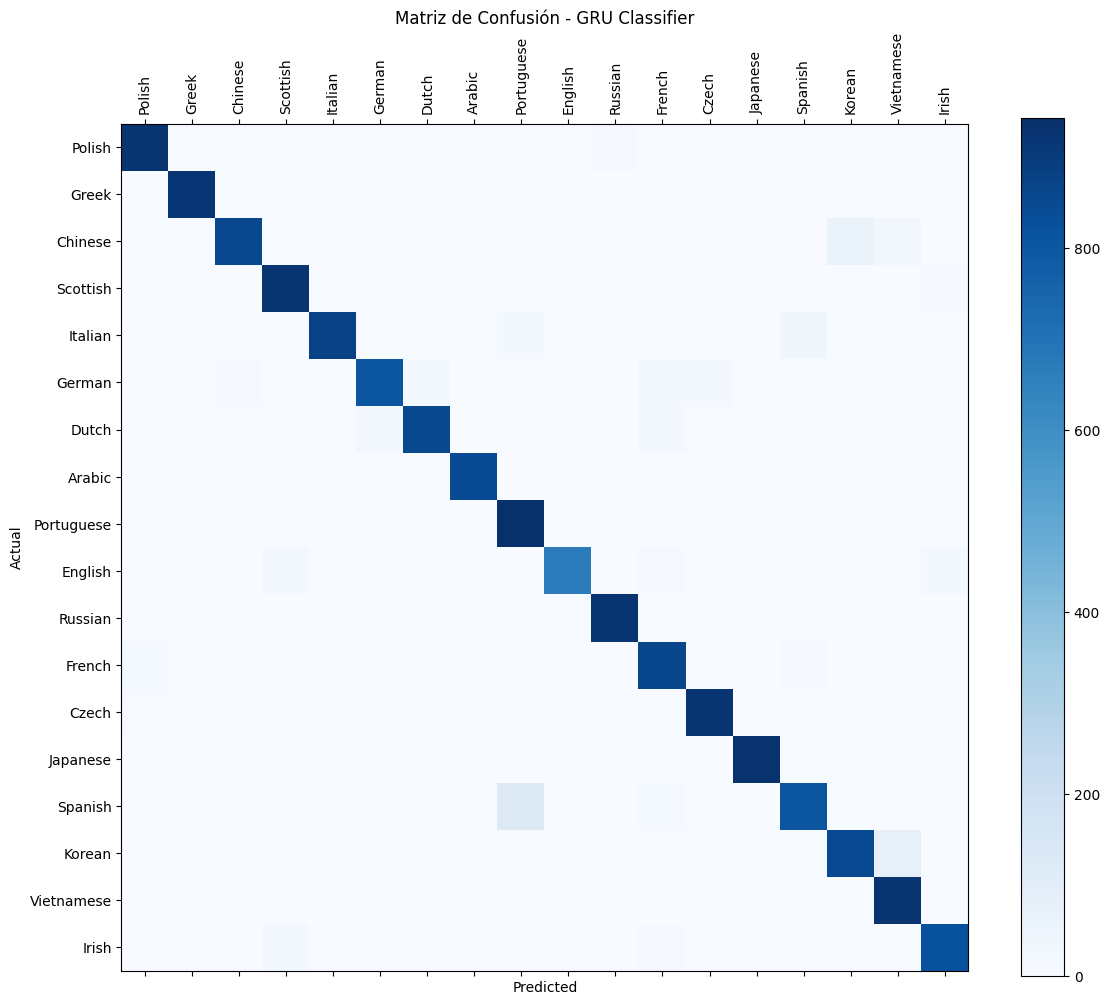

In [10]:
import importlib
from utils.eval import evaluate_model, plot_confusion_matrix
importlib.reload(eval)

# Evaluar el modelo
print("Evaluando el modelo...")
base_models = ["rnn", "lstm", "gru"]
# base_models = ["rnn"]  # Para debug, solo evaluamos el modelo RNN
models = {}

data_module = RNNDataModule(
    data_path="./data/names/", batch_size=32, num_workers=40
)

for base_model in base_models:
    # Cargar el mejor checkpoint basado en validación
    best_checkpoint = find_latest_checkpoint(base_model)
    if not best_checkpoint:
        print(f"No se encontró checkpoint para el modelo {base_model}. Saltando evaluación.")
        continue
    models[base_model] = RNNClassifier.load_from_checkpoint(best_checkpoint)

    # Evaluar el modelo
    evaluate_model(models[base_model], data_module)

    cm = models[base_model].get_confusion_matrix()
    if cm is None:
        print(f"No se pudo obtener la matriz de confusión para el modelo {base_model}.")
        continue

    # Visualizar matriz de confusión
    plot_confusion_matrix(cm, categories, f'Matriz de Confusión - {base_model.upper()} Classifier')

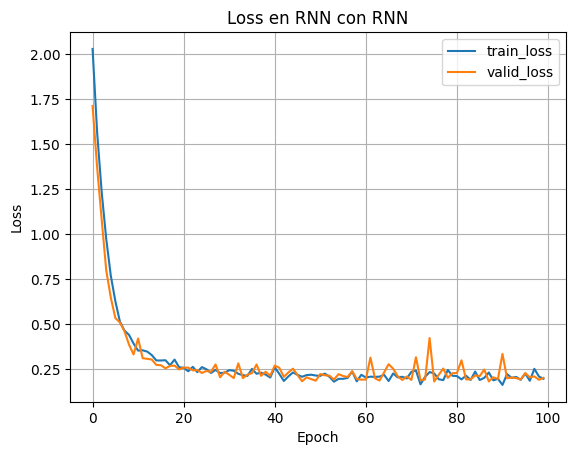

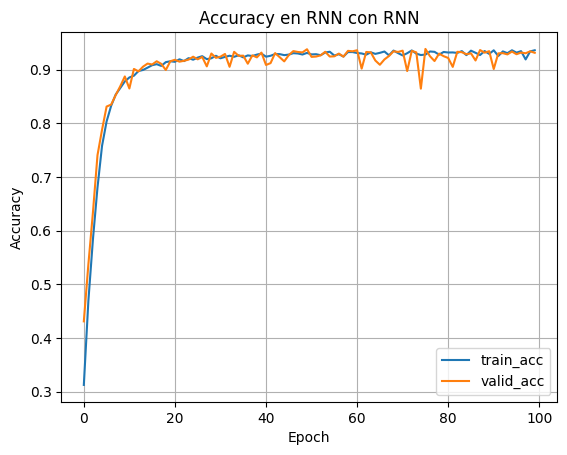

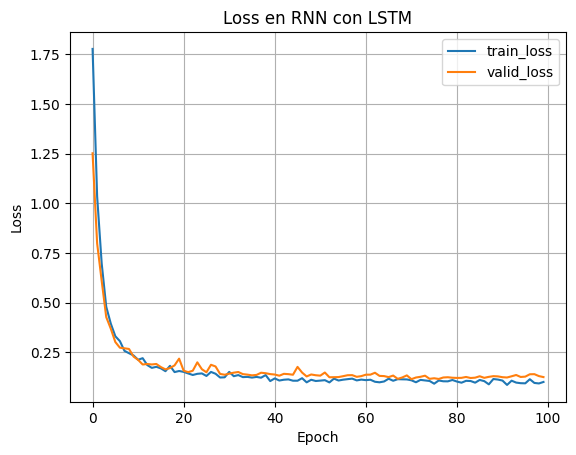

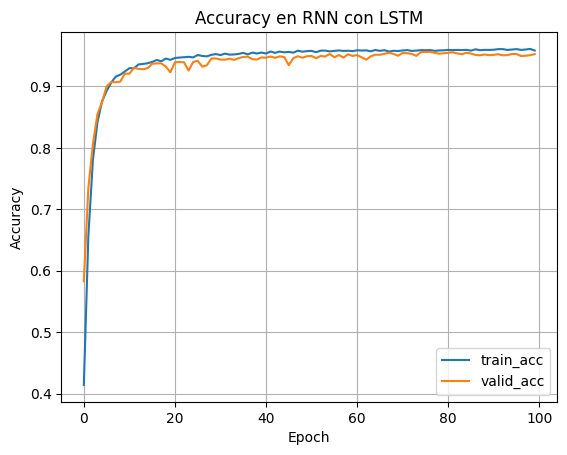

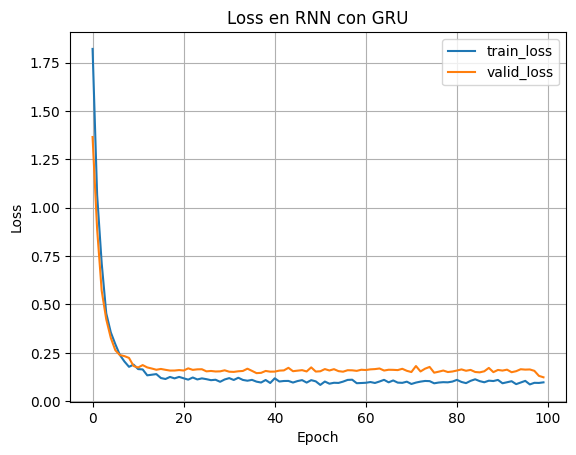

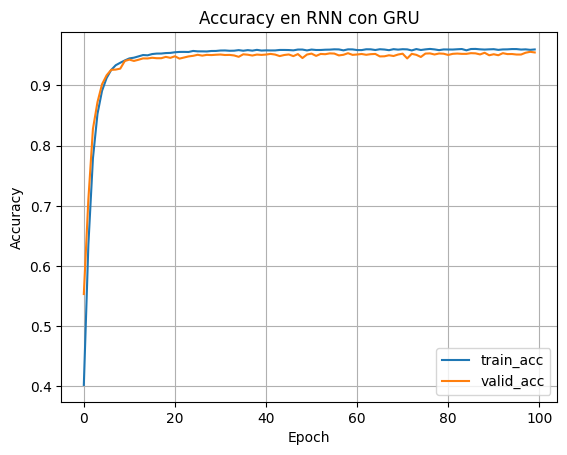

In [11]:
from utils.eval import plot_metrics

for base_model in base_models:
    plot_metrics(base_model)

## Predicciones (Caso Real)

Probamos el modelo con algunos nombres de ejemplo.

In [12]:
# Probamos con predicciones con nombres de ejemplo obtenidos de LLM
test_names = ['Dovesky', 'Jackson', 'Satoshi', 'Rodriguez', 'Mueller', 'Li', 'Nakamura', 'Smith']

# Respuestas de ChatGPT con razonmaiento:
'''
Dovesky → Russian (Slavic-sounding surname ending in -sky, common in Russian/Polish; more Russian-style spelling).
Jackson → English (patronymic meaning “son of Jack”).
Satoshi → Japanese (common Japanese given name).
Rodriguez → Spanish (patronymic surname, “son of Rodrigo”).
Mueller → German (variant of Müller, meaning “miller”).
Li → Chinese (very common Chinese surname).
Nakamura → Japanese (surname meaning “central village”).
Smith → English (occupational surname for a metalworker).
'''
test_names_origins = {
    'Dovesky': 'Russian',
    'Jackson': 'English',
    'Satoshi': 'Japanese',
    'Rodriguez': 'Spanish',
    'Mueller': 'German',
    'Li': 'Chinese',
    'Nakamura': 'Japanese',
    'Smith': 'English'
}

for base_model in base_models:
    print(f"\nPredicciones del modelo {base_model.upper()}:")
    print("=" * 90)
    
    # Recopilar todas las predicciones silenciosamente
    all_results = {}
    for name in test_names:
        predictions = predict_name_origin(models[base_model], name, categories, n_predictions=3, verbose=False)
        all_results[name] = predictions
    
    # Crear tabla compacta por nombre con ground truth
    print(f"\n{'Test Name':<12} {'Real Origin':<12} {'1st Prediction':<18} {'2nd Prediction':<18} {'3rd Prediction':<18}")
    print("-" * 110)
    
    correct_predictions = 0
    total_predictions = len(test_names)
    
    for name in test_names:
        predictions = all_results[name]
        ground_truth = test_names_origins[name]
        first_prediction = predictions[0][1]  # Get the category of the first prediction
        
        # Check if first prediction matches ground truth
        is_correct = "✓" if first_prediction == ground_truth else "✗"
        if first_prediction == ground_truth:
            correct_predictions += 1
        
        row = f"{name:<12} {ground_truth:<12}"
        
        for log_prob, category in predictions:
            prob = np.exp(log_prob)
            # Highlight correct prediction with asterisk
            marker = "*" if category == ground_truth else " "
            row += f" {category} ({prob:.3f}){marker} "
        
        print(row + f" {is_correct}")
    
    print("=" * 90)



Predicciones del modelo RNN:

Test Name    Real Origin  1st Prediction     2nd Prediction     3rd Prediction    
--------------------------------------------------------------------------------------------------------------
Dovesky      Russian      Russian (0.838)*  English (0.127)   Czech (0.027)   ✓
Jackson      English      Scottish (0.930)   English (0.067)*  Russian (0.002)   ✗
Satoshi      Japanese     Japanese (0.991)*  Italian (0.004)   Portuguese (0.002)   ✓
Rodriguez    Spanish      Spanish (0.883)*  French (0.068)   Portuguese (0.042)   ✓
Mueller      German       German (0.945)*  English (0.024)   French (0.014)   ✓
Li           Chinese      Italian (0.954)   Portuguese (0.017)   Japanese (0.017)   ✗
Nakamura     Japanese     Japanese (0.998)*  Arabic (0.001)   Russian (0.001)   ✓
Smith        English      Korean (0.716)   Chinese (0.222)   German (0.025)   ✗

Predicciones del modelo LSTM:

Test Name    Real Origin  1st Prediction     2nd Prediction     3rd Prediction    

## Discusión y Conclusiones

Los experimentos realizados con tres arquitecturas diferentes (RNN, LSTM, GRU) permiten evaluar el rendimiento relativo de cada una de éstas arquitecturas. En el caso de RNN, implementa un modelo base con menor complejidad computacional, la convergencia durante el entrenamiento es ligeramente más lenta y ruidosa pero al final el performance es comparable para resolver el problema con los datos obtenidos. La LSTM, al ser una arquitectura con gates que maneja mejor las dependencias a largo plazo, se espera tener un mejor performance, no obstante, para el problema presentado la diferencia es minima y la complejidad de la arquitectura no da una mayor ventaja. En cuanto a GRU, ofrece un performance muy similar a los otros modelos, con una convergencia rápida al igual que la LSTM y una arquitectura que ofrece balance en cuanto a la complejidad vs el performance entre la RNN y LSTM.

La implementación con PyTorch Lightning ofrece las siguientes ventajas:

1. **Código más limpio y modular**: Separación clara de responsabilidades
2. **Mejor manejo de experimentos**: Logging automático y configuración fácil
3. **Escalabilidad**: Fácil adaptación a diferentes recursos de hardware
4. **Reproducibilidad**: Mejor control de semillas y configuraciones
5. **Funcionalidades avanzadas**: Early stopping, checkpointing, etc.
